## **Import necessary library and some testing with dataset**

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from torch.nn.utils.rnn import pad_sequence
import statistics
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import torch

In [ ]:
#path to dataset
data_path = '/content/drive/MyDrive/DatasetImageCaptioning/'
# data_path = './'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Read dataset
df = pd.read_csv(data_path + 'captions.txt')
df.head(7)
df = df.head(100)

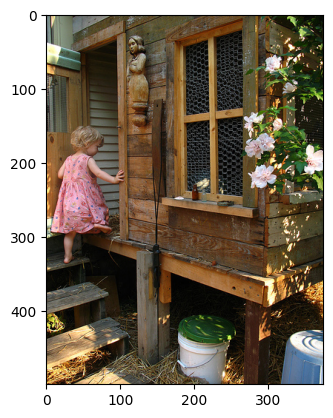

Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .


In [ ]:

data_idx = 0
image_path = data_path + 'Images/' + df.iloc[0,0] 
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

## **Enhanced Text Tokenization with SpaCy and Vocabulary Building**

In [ ]:

#using spacy for the better text tokenization
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self,freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        self.stoi = {v:k for k,v in self.itos.items()}
        self.freq_threshold = freq_threshold
    def __len__(self): return len(self.itos)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)] 

    def build_vocab(self, sentence_list):
        frequencies = Counter() 
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]

## **Image Captioning Dataset with Vocabulary Integration**

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self,root_dir,captions_file,transform=None,freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        #Get image and caption colum from the dataframe
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]
        #Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist()) 
    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.root_dir,img_name)
        img = Image.open(img_location).convert("RGB")

        #apply the transfromation to the image
        if self.transform is not None:
            img = self.transform(img)
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]

        return img, torch.tensor(caption_vec)

In [ ]:

#defing the transform to be applied
transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
def show_image(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

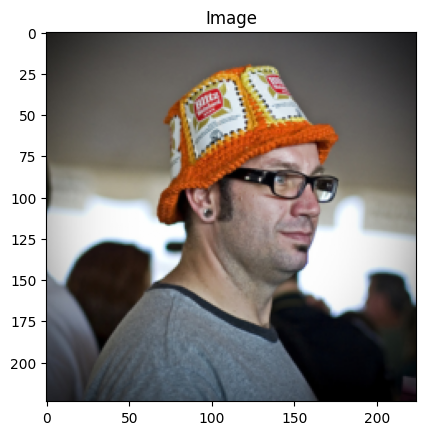

Token: tensor([   1,    4,   14,    8,   24,   25,   18, 1948,   19,  211,    5,    2])
Sentence:
['<SOS>', 'a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.', '<EOS>']


In [ ]:
#testing the dataset class
dataset =  FlickrDataset(
    root_dir = data_path + '/Images',
    captions_file = data_path + 'captions.txt',
    transform=transforms
)

img, caps = dataset[20]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [ ]:

class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch] 
        imgs = torch.cat(imgs,dim=0) 

        targets = [item[1] for item in batch] 
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx) 
        return imgs,targets

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, train_CNN, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.encoded_image_size = encoded_image_size

        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2] 
        self.resnet = nn.Sequential(*modules)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size)) 

        # Fine tune
        for param in self.resnet.parameters():
            param.requires_grad = False 
        # Only train last 2 layers of resnet if at all required
        if train_CNN:
            for c in list(self.resnet.children())[-2:]:
                for p in c.parameters():
                    p.requires_grad = train_CNN


    def forward(self, images):
        features = self.resnet(images) # (batch_size, num_features, H, W)
        features = self.adaptive_pool(features) 
        features = features.permute(0, 2, 3, 1) 
        return features

## **Building LSTM decoder with Attention**

In [ ]:

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha



In [ ]:

class DecoderRNN(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim, dropout):
        """
        decoder_dim is hidden_size for lstm cell
        """
        super(DecoderRNN, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial hidden state of LSTMCell
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  # linear layer to find initial cell state of LSTMCell
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)  # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)  # linear layer to find scores over vocabulary
        self.init_weights()  # initialize some layers with the uniform distribution

    def init_weights(self):

        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        decode_length = encoded_captions.size(1)-1

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, decode_length, vocab_size).to(device)
        alphas = torch.zeros(batch_size, decode_length, num_pixels).to(device)

        for t in range(decode_length):

            attention_weighted_encoding, alpha = self.attention(encoder_out, h)
            gate = self.sigmoid(self.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding

            h, c = self.decode_step(torch.cat([embeddings[:, t, :], attention_weighted_encoding], dim=1), (h, c))  #(batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:, t, :] = preds
            alphas[:, t, :] = alpha

        return predictions, alphas

In [ ]:
class CNNtoRNN(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.5, train_CNN=False):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(train_CNN=train_CNN)
        self.decoderRNN = DecoderRNN(attention_dim, embed_dim, decoder_dim, vocab_size,
                                     encoder_dim=encoder_dim, dropout=dropout)

    def forward(self, images, captions):
        encoder_out = self.encoderCNN(images)
        outputs, alphas = self.decoderRNN(encoder_out, captions)
        return outputs, alphas

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = [1]

        with torch.no_grad():
            encoder_out = self.encoderCNN(image)

            batch_size = encoder_out.size(0)
            encoder_dim = encoder_out.size(-1)
            vocab_size = self.decoderRNN.vocab_size

            encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
            num_pixels = encoder_out.size(1)

            # initially start with sos as a predicted word
            predicted = torch.tensor([vocabulary.stoi["<SOS>"]]).to(device)
            h, c = self.decoderRNN.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

            for t in range(max_length):
                embeddings = self.decoderRNN.embedding(predicted)  # (1, embed_dim)

                attention_weighted_encoding, alpha = self.decoderRNN.attention(encoder_out, h)
                gate = self.decoderRNN.sigmoid(self.decoderRNN.f_beta(h))  # gating scalar, (batch_size_t, encoder_dim)
                attention_weighted_encoding = gate * attention_weighted_encoding

                h, c = self.decoderRNN.decode_step(torch.cat([embeddings, attention_weighted_encoding], dim=1), (h, c))  #(batch_size_t, decoder_dim)
                preds = self.decoderRNN.fc(self.decoderRNN.dropout(h))  # (batch_size_t, vocab_size)

                predicted = preds.argmax(1)
                result_caption.append(predicted.item())

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

            return [vocabulary.itos[idx] for idx in result_caption]

## **Building LSTM Decoder without Attention**

In [ ]:
class DecoderRNNWithoutAttention(nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.5):
        super(DecoderRNNWithoutAttention, self).__init__()
        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)

        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions):
        batch_size = encoder_out.size(0)

        encoder_out = encoder_out.view(batch_size, -1, self.encoder_dim)
        num_pixels = encoder_out.size(1)

        embeddings = self.embedding(encoded_captions)

        h, c = self.init_hidden_state(encoder_out)

        decode_length = encoded_captions.size(1) - 1

        predictions = torch.zeros(batch_size, decode_length, self.vocab_size).to(encoder_out.device)

        for t in range(decode_length):
            h, c = self.decode_step(embeddings[:, t, :], (h, c))
            preds = self.fc(self.dropout(h))
            predictions[:, t, :] = preds

        return predictions


In [ ]:
class CNNtoRNNWithoutAttention(nn.Module):
    def __init__(self, embed_dim, decoder_dim, vocab_size, encoder_dim=512, dropout=0.5, train_CNN=False):
        super(CNNtoRNNWithoutAttention, self).__init__()
        self.encoderCNN = EncoderCNN(train_CNN=train_CNN)
        self.decoderLSTM = DecoderRNNWithoutAttention(embed_dim, decoder_dim, vocab_size, encoder_dim=encoder_dim, dropout=dropout)

    def forward(self, images, captions):
        encoder_out = self.encoderCNN(images)
        outputs = self.decoderLSTM(encoder_out, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = [1]

        with torch.no_grad():
            encoder_out = self.encoderCNN(image)

            batch_size = encoder_out.size(0)
            encoder_dim = encoder_out.size(-1)
            vocab_size = self.decoderLSTM.vocab_size

            encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
            num_pixels = encoder_out.size(1)

            predicted = torch.tensor([vocabulary.stoi["<SOS>"]]).to(encoder_out.device)
            h, c = self.decoderLSTM.init_hidden_state(encoder_out)

            for t in range(max_length):
                embeddings = self.decoderLSTM.embedding(predicted)

                h, c = self.decoderLSTM.decode_step(embeddings, (h, c))
                preds = self.decoderLSTM.fc(self.decoderLSTM.dropout(h))

                predicted = preds.argmax(1)
                result_caption.append(predicted.item())

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

            return [vocabulary.itos[idx] for idx in result_caption]

In [ ]:
def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
    isTrain=True
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=CapsCollate(pad_idx=pad_idx),
    )

    return loader, dataset

## **Initializing parameter**

In [ ]:
RESIZE = 356
CROP = 299

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
import torchvision.transforms as transforms

torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

transform = transforms.Compose(
    [
        transforms.Resize((RESIZE, RESIZE)),
        transforms.RandomCrop((CROP, CROP)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
train_loader, dataset = get_loader(
    data_path + "/Images",
    data_path + "/captions.txt" ,
    transform=transform,
    num_workers=8,
    batch_size=8,
    shuffle=True,
    isTrain=True
)

# Hyperparameters
embed_dim = 700
attention_dim = 700
decoder_dim = 700
dropout = 0.5
vocab_size = len(dataset.vocab)
learning_rate = 1e-03
num_epochs = 8
load_model = False
save_model = True
train_CNN = False
alpha_c = 1

cuda


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Training with both models and saving models**

In [ ]:
def train_WithAttention():
    step = 0
    model = CNNtoRNN(attention_dim, embed_dim, decoder_dim, vocab_size, train_CNN=train_CNN, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    losses = [] #To store loss values for plotting
    for epoch in range(num_epochs):
        loss = 400
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": 0,
            }
            save_checkpoint(checkpoint)
            torch.save(model.state_dict(), 'Attention.pth.tar')

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs, alphas = model(imgs, captions.permute(1, 0))
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.permute(1, 0)[:, 1:].reshape(-1))
            step += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())  # Append the current loss value to the list

        print('Epoch {} completed with loss {}'.format(epoch+1, loss))
    return losses
attention_loss = train_WithAttention()

In [ ]:
def train_WithoutAttention():
    step = 0
    model = CNNtoRNNWithoutAttention(embed_dim, decoder_dim, vocab_size ,train_CNN=train_CNN, dropout=dropout).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    losses = []  # To store loss values for plotting

    for epoch in range(num_epochs):
        loss = 400
        if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": 0,
            }
            save_checkpoint(checkpoint)
            torch.save(model.state_dict(), 'NoAttention.pth.tar')

        for idx, (imgs, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False
        ):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions.permute(1, 0))
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.permute(1, 0)[:, 1:].reshape(-1))
            step += 1

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())  # Append the current loss value to the list

        print('Epoch {} completed with loss {}'.format(epoch+1, loss))
    return losses
print(device)
no_attention_loss = train_WithoutAttention()

In [ ]:
plt.figure(figsize= (20, 8))
plt.plot(attention_loss, label='With Attention')
plt.plot(no_attention_loss, label='Without Attention')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.xlim(0, 5000)
plt.legend()
plt.show()

## **Loading pre-trained models and testing**

In [ ]:
model = CNNtoRNN(attention_dim, embed_dim, decoder_dim, vocab_size, train_CNN=train_CNN, dropout=dropout).to(device)
model.load_state_dict(torch.load("/content/Attention.pth.tar"))
model.eval();

In [ ]:
base_path = '/content/drive/MyDrive/DatasetImageCaptioning/'
def showAndCaptionImage(img, model):

    img = Image.open(base_path + img).convert("RGB")
    plt.imshow(img)
    plt.show()
    img = transform(img)
    caption = model.caption_image(img.unsqueeze(0).to(device), dataset.vocab)[1:-1]
    captionStr = ""
    for e in caption:
        captionStr += e + " "
    print(captionStr)

subjective_images = ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg']
for image in subjective_images:
    showAndCaptionImage(image, model)

In [ ]:
model = CNNtoRNNWithoutAttention(embed_dim, decoder_dim, vocab_size, train_CNN=train_CNN, dropout=dropout).to(device)
model.load_state_dict(torch.load("/content/NoAttention.pth.tar"))
model.eval();

In [ ]:
base_path = '/content/drive/MyDrive/DatasetImageCaptioning/'
def showAndCaptionImage(img, model):

    img = Image.open(base_path + img).convert("RGB")
    plt.imshow(img)
    plt.show()
    img = transform(img)
    caption = model.caption_image(img.unsqueeze(0).to(device), dataset.vocab)[1:-1]
    captionStr = ""
    for e in caption:
        captionStr += e + " "
    print(captionStr)

subjective_images = ['test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg']
for image in subjective_images:
    showAndCaptionImage(image, model)